# Выбор локации для скважины

Поступила задача от добывающей компании «X». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Также необходимо проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**
Данные геологоразведки трёх регионов находятся в файлах:
* `/datasets/geo_data_0.csv.` 
* `/datasets/geo_data_1.csv.` 
* `/datasets/geo_data_2.csv.` 
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).


Условия задачи:
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Шаг 1. Загрузка и подготовка данных

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [92]:
try:
    geo_data_0 = pd.read_csv('C:\Data\geo_data_0.csv') #загру
    geo_data_1 = pd.read_csv('C:\Data\geo_data_1.csv')
    geo_data_2 = pd.read_csv('C:\Data\geo_data_2.csv')
except:
    geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [93]:
geo_data_0.info() #изучим данные
print()
geo_data_1.info()
print()
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Nul

In [94]:
def check_columns(data_frame):
    for column in data_frame.columns:
        print('Уникальные значения столбца', column)
        print(data_frame[column].unique())

In [95]:
check_columns(geo_data_0)
print()
check_columns(geo_data_1)
print()
check_columns(geo_data_2)

Уникальные значения столбца id
['txEyH' '2acmU' '409Wp' ... '3rnvd' '7kl59' '1CWhH']
Уникальные значения столбца f0
[0.70574498 1.33471129 1.02273226 ... 1.02958465 0.99816289 1.76475393]
Уникальные значения столбца f1
[-0.4978225  -0.34016425  0.15199044 ...  0.01878693 -0.52858167
 -0.26641676]
Уникальные значения столбца f2
[ 1.22116995  4.36508033  1.41992624 ... -1.34830814  1.58386866
  5.72284937]
Уникальные значения столбца product
[105.28006184  73.03775027  85.26564713 ...  64.37544259  74.04076435
 149.63324561]

Уникальные значения столбца id
['kBEdx' '62mP7' 'vyE1P' ... '09gWa' 'rqwUm' 'relB0']
Уникальные значения столбца f0
[-15.00134818  14.27208781   6.26318735 ...  -7.37889139   0.66571381
  -3.42613898]
Уникальные значения столбца f1
[-8.27599995 -3.47508322 -5.94838579 ... -3.08410387 -6.15259286
 -7.7942742 ]
Уникальные значения столбца f2
[-5.87601369e-03  9.99182737e-01  5.00116016e+00 ...  4.99865060e+00
  1.00014635e+00 -3.29851829e-03]
Уникальные значения столб

In [96]:
geo_data_0.duplicated().sum()


0

In [97]:
geo_data_1.duplicated().sum()

0

In [98]:
geo_data_2.duplicated().sum()

0

**Дубликатов нет.**

In [99]:
geo_data_0.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [100]:
geo_data_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [101]:
geo_data_2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

**Пропусков нет нет**

**Удалим столбцы id, поскольку они не несут существенной информации для исследования**

In [102]:
geo_data_0 = geo_data_0.drop(['id'], axis=1)
geo_data_1 = geo_data_1.drop(['id'], axis=1)
geo_data_2 = geo_data_2.drop(['id'], axis=1)

**Проверим число нулевых значений**

In [103]:
def check_zeros(data, target_name):
    zeros = data[data[target_name] == 0][target_name].count()
    percent = zeros / data.shape[0]
    print('Количество нулевых знчений:', zeros)
    print('Процент нулевых значений:', percent)
        

In [104]:
check_zeros(geo_data_0, 'product')
print()
check_zeros(geo_data_1, 'product')
print()
check_zeros(geo_data_2, 'product')

Количество нулевых знчений: 1
Процент нулевых значений: 1e-05

Количество нулевых знчений: 8235
Процент нулевых значений: 0.08235

Количество нулевых знчений: 1
Процент нулевых значений: 1e-05


In [105]:
geo_data_0[geo_data_0['product'] == 0]

,f0,f1,f2,product
57263,-0.702064,0.375992,0.236572,0.0


In [106]:
geo_data_1[geo_data_1['product'] == 0]

,f0,f1,f2,product
11,16.320755,-0.562946,-0.001783,0.0
13,6.695604,-0.749449,-0.007630,0.0
62,21.418478,-5.134490,-0.002836,0.0
63,6.822701,3.104979,-0.000723,0.0
77,6.750150,-11.893512,-0.001601,0.0
...,...,...,...,...
99936,5.085749,-3.980305,0.005063,0.0
99948,8.277805,-9.178818,0.003275,0.0
99956,13.343983,-1.290200,0.005980,0.0
99961,13.854163,-11.528089,-0.005556,0.0


In [107]:
geo_data_2[geo_data_2['product'] == 0]

,f0,f1,f2,product
68149,-0.865596,-1.615247,-4.126441,0.0


**Изучим гистограммы по столбцу `product`.**

In [108]:
def oil_hist(series, bins, xlim_max, ylim_max):
    plt.figure(figsize=[12, 9])
    plt.hist(series, bins=bins)
    plt.xlim([0, xlim_max])
    plt.ylim([0, ylim_max])
    
    plt.xlabel('Объём нефти одной скважены тыс. баррелей')
    plt.ylabel('Количество скважин')
    
    plt.title('Гистограмма распределения по объёму скважин')
    plt.show()

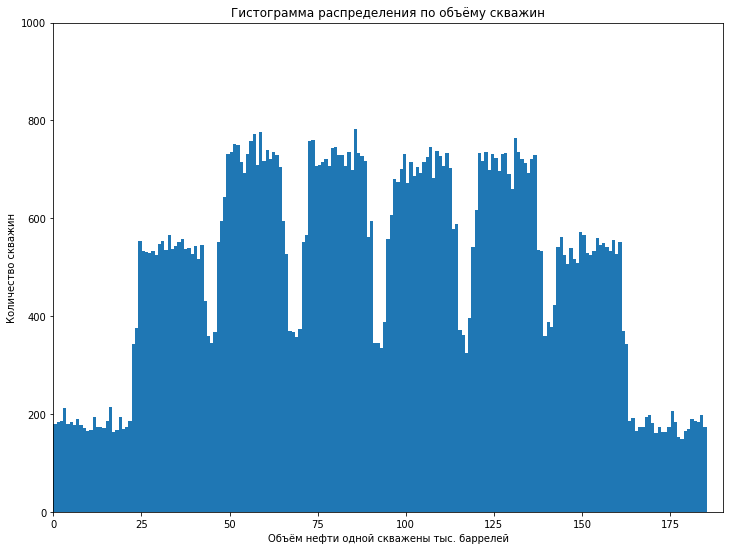

In [109]:
oil_hist(geo_data_0['product'], 200, 190, 1000)

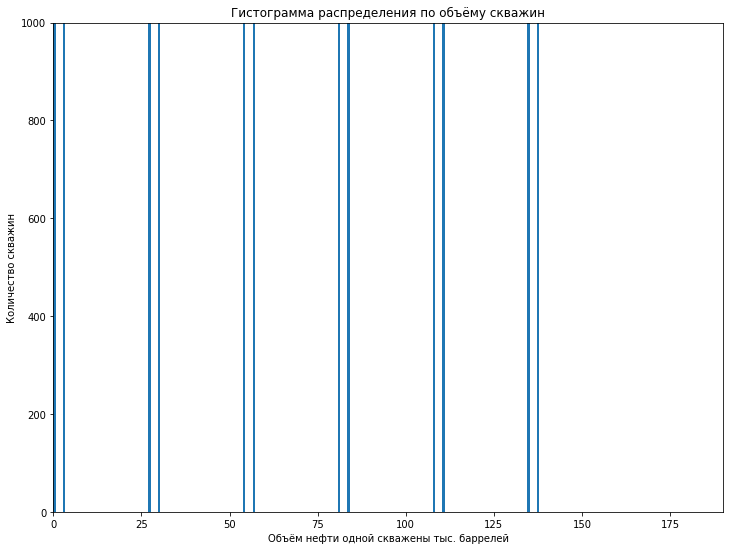

In [110]:
oil_hist(geo_data_1['product'], 200, 190, 1000)

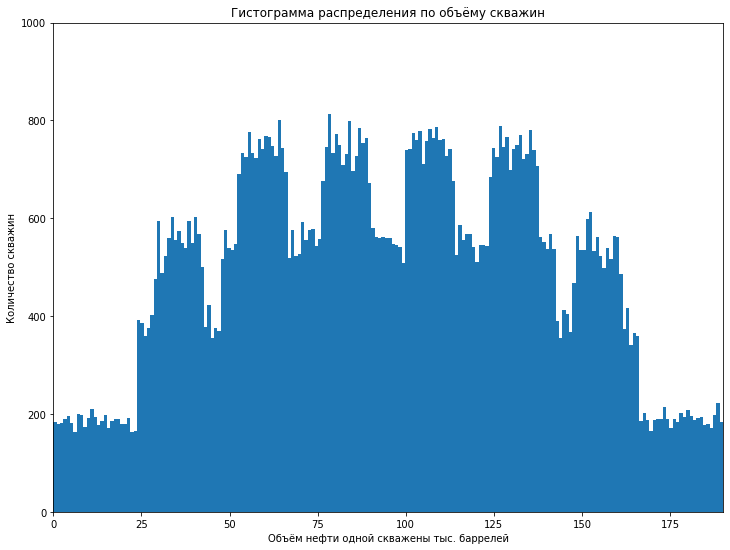

In [111]:
oil_hist(geo_data_2['product'], 200, 190, 1000)

**Признаки:**
* f0
* f1
* f2

**Целевой признак:**
* product


**Вывод по Шагу 1: Данные готовы к обучению. Вызывают сомнения данные по 2й гистограмме, поскольку при сравнении с остальными гистограммами, можно предположить, что данные были утеряны. Первая и третья гистограмма соответствует закону нормального распределения. Данные же по второй гистограмме намекают на то, что данные были введены либо некорректно, либо специально.**

## Шаг 2. Обучение и проверка модели

**Проверим качество линейной регрессии с текущим значением признаков и с масштабируемыми признаками. Проверим на geo_data_0. Выполним разбивку на неподготовленном датафрейме.**

* features - данные без масштаба
* features_s - данные с масштабом

In [112]:
def test_split(data, target):
    features = data.drop([target], axis=1)
    target = data[target]
    
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=5062020) #делим выбокру на обучающую и валидационную
    
    return features_train, features_valid, target_train, target_valid

In [113]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = test_split(geo_data_0, 'product')

features_train_0.head()

,f0,f1,f2
78638,0.602333,-0.445623,3.165303
67323,-0.984306,0.046746,0.400594
25303,0.085069,0.050226,-0.374703
80751,0.174317,0.011649,4.180446
28950,0.372650,1.031981,2.904160


In [114]:
def test_split_scaled(data, numeric, target):
    geo_data_s = data.copy()
    
    features_s = geo_data_s.drop([target], axis=1)
    target_s = geo_data_s[target]
    
    features_train_s, features_valid_s, target_train_s, target_valid_s = train_test_split(
    features_s, target_s, test_size=0.25, random_state=562020)
    
    scaler = StandardScaler()
    scaler.fit(features_train_s[numeric])
    features_train_s[numeric] = scaler.transform(features_train_s[numeric])
    features_valid_s[numeric] = scaler.transform(features_valid_s[numeric])
    
    return features_train_s, features_valid_s, target_train_s, target_valid_s

**Данные изменились. Првоедём обучение на линейонй регрерссии без изменения данных**

In [115]:
model = LinearRegression()

model.fit(features_train_0, target_train_0)
predicted_target_0 = model.predict(features_valid_0)
print('RMSE:', mean_squared_error(target_valid_0, predicted_target_0)**0.5)

RMSE: 37.401957199217094


**Теперь проверим RMSE на масштабиремых данных**

In [116]:
features_train_0s, features_valid_0s, target_train_0s, target_valid_0s = test_split_scaled(
geo_data_0, ['f0', 'f1', 'f2'], 'product')
model.fit(features_train_0s, target_train_0s)
predicted_target_0s = model.predict(features_valid_0s)
print('RMSE:', mean_squared_error(target_valid_0s, predicted_target_0s)**0.5)


RMSE: 37.61426830823484


/tmp/ipykernel_734/1513026570.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_s[numeric] = scaler.transform(features_train_s[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [117]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = test_split(geo_data_1, 'product')
model.fit(features_train_1, target_train_1)
predicted_target_1 = model.predict(features_valid_1)
print('RSME:', mean_squared_error(target_valid_1, predicted_target_1)**0.5)

features_train_1s, features_valid_1s, target_train_1s, target_valid_1s = test_split_scaled(geo_data_1, ['f0', 'f1', 'f2'], 'product')
model.fit(features_train_1s, target_train_1s)
predicted_target_1s = model.predict(features_valid_1s)
print('RSME:', mean_squared_error(target_valid_1s, predicted_target_1s)**0.5)

RSME: 0.8874258342572864
RSME: 0.889459761512849


/tmp/ipykernel_734/1513026570.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_s[numeric] = scaler.transform(features_train_s[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [118]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = test_split(geo_data_2, 'product')
model.fit(features_train_2, target_train_2)
predicted_target_2 = model.predict(features_valid_2)
print('RSME:', mean_squared_error(target_valid_2, predicted_target_2)**0.5)

features_train_2s, features_valid_2s, target_train_2s, target_valid_2s = test_split_scaled(geo_data_2, ['f0', 'f1', 'f2'], 'product')
model.fit(features_train_2s, target_train_2s)
predicted_target_2s = model.predict(features_valid_2s)
print('RSME:', mean_squared_error(target_valid_2s, predicted_target_2s)**0.5)

RSME: 40.18553497171235
RSME: 40.02667239030251


/tmp/ipykernel_734/1513026570.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_s[numeric] = scaler.transform(features_train_s[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

**Из данных выше можно сделать вывод, что данные не нуждаются в масштабировании.**

**Проверим показатель RMSE на других параметрах модели**

In [119]:
model = LinearRegression(normalize=True)
model.fit(features_train_0, target_train_0)
predicted_target_0 = model.predict(features_valid_0)
print('RMSE:', mean_squared_error(target_valid_0, predicted_target_0)**0.5)

RMSE: 37.401957199217094


In [120]:
model = LinearRegression(fit_intercept=False)
model.fit(features_train_0, target_train_0)
predicted_target_0 = model.predict(features_valid_0)
print('RMSE:', mean_squared_error(target_valid_0, predicted_target_0)**0.5)

RMSE: 60.749819777751355


**Изменение стадартных значений не помогло улучшить модель. Сделаем вывод предсказанного запаса с реальным и выведем RMSE.**

In [121]:
model = LinearRegression()

def oil_predict(data, target_name):
    features = data.drop([target_name], axis=1)
    target = data[target_name]
    
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=5062020)
    
    model.fit(features_train, target_train)
    predicted_target = model.predict(features_valid)
    data = {'real_product' : target_valid,
            'predicted_product' : predicted_target
    }
    data_frame = pd.DataFrame(data, columns = ['real_priduct', 'predicted_product'])
    rmse = mean_squared_error(target_valid, predicted_target)**0.5
    mean = data_frame['predicted_product'].mean()
    oil_sum = data_frame['predicted_product'].sum()
    return data_frame, rmse, mean, oil_sum

In [122]:
model = LinearRegression()

def oil_predict(df, target_name):
    features = df.drop([target_name] , axis=1)
    target = df[target_name]
    
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=5062020)
    
    model.fit(features_train, target_train)
    predicted_target = model.predict(features_valid)
    data = {'real_product' : target_valid,
            'predicted_product' : predicted_target         
    }
    data_frame = pd.DataFrame(data, columns = ['real_product', 'predicted_product'])
    rmse = mean_squared_error(target_valid, predicted_target)**0.5
    mean = data_frame['predicted_product'].mean()
    oil_sum = data_frame['predicted_product'].sum()
    return data_frame, rmse, mean, oil_sum

In [123]:
geo_data_0_predicted, geo_data_0_rmse, geo_data_0_predicted_mean, geo_data_0_predicted_sum = oil_predict(geo_data_0, 'product')
print(geo_data_0_predicted.head())
print('RMSE:', geo_data_0_rmse)
print('Средний запас сырья:', geo_data_0_predicted_mean)

       real_product  predicted_product
87351    145.407098         110.644337
52805    131.589165          76.793446
6583     101.596316         103.711077
34986      8.123407          53.135348
8253     169.834019         151.656408
RMSE: 37.401957199217094
Средний запас сырья: 92.52620585803338


In [124]:
geo_data_1_predicted, geo_data_1_rmse, geo_data_1_predicted_mean, geo_data_1_predicted_sum = oil_predict(geo_data_1, 'product')
print(geo_data_1_predicted.head())
print('RMSE:', geo_data_1_rmse)
print('Средний запас сырья:', geo_data_1_predicted_mean)

       real_product  predicted_product
87351     53.906522          54.336477
52805      3.179103           3.756436
6583      30.132364          31.266991
34986     26.953261          26.692436
8253      30.132364          31.128898
RMSE: 0.8874258342572864
Средний запас сырья: 68.27820207556354


In [125]:
geo_data_2_predicted, geo_data_2_rmse, geo_data_2_predicted_mean, geo_data_2_predicted_sum = oil_predict(geo_data_2, 'product')
print(geo_data_2_predicted.head())
print('RMSE:', geo_data_2_rmse)
print('Средний запас сырья:', geo_data_2_predicted_mean)

       real_product  predicted_product
87351    140.971569          62.929196
52805    125.190694          98.323840
6583      94.544056          79.920918
34986    107.208380         104.706020
8253     173.924418         114.066050
RMSE: 40.18553497171235
Средний запас сырья: 94.94294307153748


**Оценим общий запас по регионам по предсказанным данным**

In [126]:
print('Общий показатель запасов в позиции 0:', geo_data_0_predicted_sum)
print('Суммарный реальный показатель запасов в позиции 0:', geo_data_0_predicted['real_product'].sum())
print()
print('Общий показатель запасов в позиции 1:', geo_data_1_predicted_sum)
print('Суммарный реальный показатель запасов в позиции 1:', geo_data_1_predicted['real_product'].sum())
print()
print('Общий показатель запасов в позиции 2:', geo_data_2_predicted_sum)
print('Суммарный реальный показатель запасов в позиции 2:', geo_data_2_predicted['real_product'].sum())

Общий показатель запасов в позиции 0: 2313155.1464508343
Суммарный реальный показатель запасов в позиции 0: 2313395.805667925

Общий показатель запасов в позиции 1: 1706955.0518890887
Суммарный реальный показатель запасов в позиции 1: 1706710.3444370048

Общий показатель запасов в позиции 2: 2373573.576788437
Суммарный реальный показатель запасов в позиции 2: 2378821.7815969232


**Вывод по Шагу 2:**
* Данные предсказаний примерно совпадают с данными по предсказанным значениям. Лучше всего модель была предсказана во втором регионе (geo_data_1 - 0.88), затем в первом (geo_data_0 - 37.61), потом в третьем (geo_data_2 - 40.18).
* Данные по второй модели, скорее всего из-за скошенности переобучились.
* Из-за недостака данных, не имеет смысла рассматривать второй регион как прибыльное.

## Шаг. 3 Подготовка к расчёту прибыли

**Изучим все регионы на прибыль и риски. Будем выбирать между первым и третьим регионом, исходя из предыдущих выводов.**

**Создадим переменные об экономической информации**

In [127]:
budget = budget = 1e+07 #расчёт будет идти в 1 тыс. баррелях нефти, поэтому будем пользоваться такой запиью
chosen_points = 500
best_points = 200
price_per_barrel = 450

**Рассчитаем безубыточную стоимость сырья на 200 месторождениях. И найдём среднее количество сырья необходимого для месторождения**

In [128]:
average_profit_per_point = budget / best_points
print('Средняя прибыль по лучшей точке:', average_profit_per_point, 'тыс. баррелей')

average_barrels_per_point = average_profit_per_point / price_per_barrel
print('Средний объём нефти на точку:', average_barrels_per_point, 'тыс. баррелей')

average_barrels = budget / price_per_barrel
print('Средний объём нефти на регион:', average_barrels, 'тыс. баррелей')


Средняя прибыль по лучшей точке: 50000.0 тыс. баррелей
Средний объём нефти на точку: 111.11111111111111 тыс. баррелей
Средний объём нефти на регион: 22222.222222222223 тыс. баррелей


In [129]:
print('Средний запас фактической нефти на скважину в регионе 1', geo_data_0['product'].mean())
print('Средний запас фактической нефти на скважину в регионе 2', geo_data_1['product'].mean())
print('Средний запас фактической нефти на скважину в регионе 3', geo_data_2['product'].mean())

Средний запас фактической нефти на скважину в регионе 1 92.50000000000001
Средний запас фактической нефти на скважину в регионе 2 68.82500000000002
Средний запас фактической нефти на скважину в регионе 3 95.00000000000004


**Создадим функцию для расчёта прибыли на 500 местородениях.**

In [130]:
def oil_profit_calculation(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return price_per_barrel * selected.sum() - budget

**Выведим на графики предсказанные значения.**

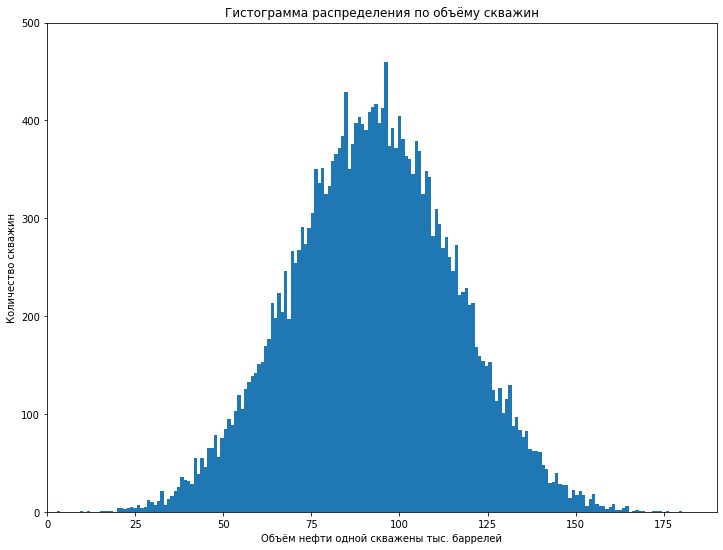

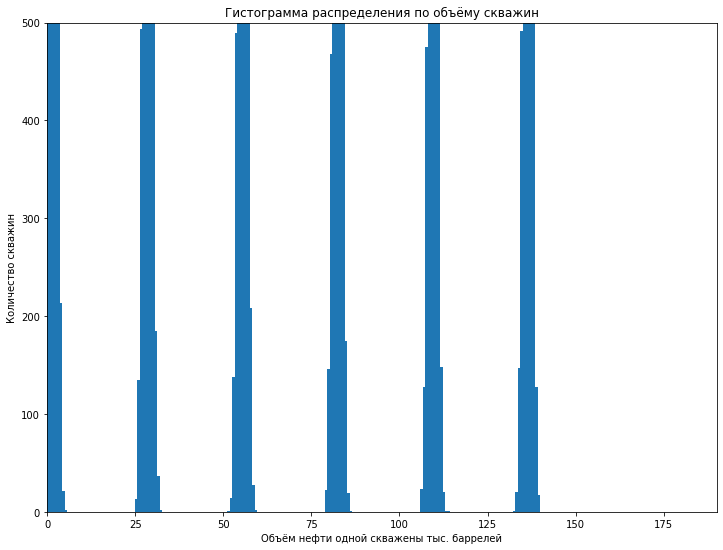

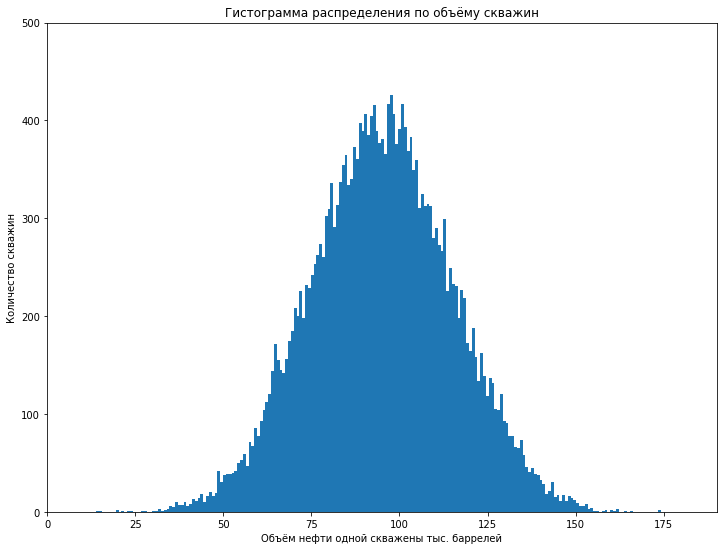

In [131]:
oil_hist(geo_data_0_predicted['predicted_product'], 200, 190, 500)
oil_hist(geo_data_1_predicted['predicted_product'], 200, 190, 500)
oil_hist(geo_data_2_predicted['predicted_product'], 200, 190, 500)

**Вывод по 3 Шагу.**

* Мы подготовили расчёт средней оценки прибыли на каждую скважину и средний объём на скважину. Была создана функция расчёта прибыли.

* Были изучены средние фактические запасы. Для первого и третьего региона высокая вероятность окупить затраты. Разброс между 92 и 95 говорит нам о том, что существует много скважин, где запасов больше необходимого среднего.

* Во втором регионе 111 тыс. баррелей на точку, что говорит о том, что существуют лучшие скважины в этом районе, однако там наименьшие запасы сырья.

## Шаг 4. Расчёт прибыли и рисков 

In [132]:
state = np.random.RandomState(5062020)
def bootstrap_1000(target, probs):
    values = []
    lost = 0
    for index in range(1000):
        target_sample =target.sample(replace=True, random_state=state, n=chosen_points)
        probs_sample = probs[target_sample.index]
        profit = oil_profit_calculation(target, probs_sample, best_points)
        if profit <  0:
            lost +=1
        values.append(profit)
            
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = lost / 1000
    return average, lower, upper, risk

In [133]:
average_0, lower_0, upper_0, risk_0 = bootstrap_1000(geo_data_0_predicted['real_product'], 
                                                     geo_data_0_predicted['predicted_product'])
print('Данные по первому региону')
print('Средняя прибыль по региону: {:.2f} тыс. рублей'.format(average_0))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс. рублей'.format(lower_0, upper_0))
print('Процент риска {:.2%}'.format(risk_0))

Данные по первому региону
Средняя прибыль по региону: 443250.40 тыс. рублей
95% доверительный интервал от -44227.32 до 919246.01 тыс. рублей
Процент риска 3.60%


In [134]:
average_1, lower_1, upper_1, risk_1 = bootstrap_1000(geo_data_1_predicted['real_product'], 
                                                     geo_data_1_predicted['predicted_product'])
print('Данные по второму региону')
print('Средняя прибыль по региону: {:.2f} тыс. рублей'.format(average_1))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс. рублей'.format(lower_1, upper_1))
print('Процент риска {:.2%}'.format(risk_1))

Данные по второму региону
Средняя прибыль по региону: 402869.66 тыс. рублей
95% доверительный интервал от -7525.27 до 825916.72 тыс. рублей
Процент риска 3.00%


In [135]:
average_2, lower_2, upper_2, risk_2 = bootstrap_1000(geo_data_2_predicted['real_product'], 
                                                     geo_data_2_predicted['predicted_product'])
print('Данные по третьему региону')
print('Средняя прибыль по региону: {:.2f} тыс. рублей'.format(average_2))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс. рублей'.format(lower_2, upper_2))
print('Процент риска {:.2%}'.format(risk_2))

Данные по третьему региону
Средняя прибыль по региону: 400201.63 тыс. рублей
95% доверительный интервал от -128526.18 до 896828.78 тыс. рублей
Процент риска 6.60%


**Вывод по Шагу 5.**

* Мы посчитали обработали данные и посчитали прибыль и риски.

* Мы отсеиваем первый и третий регион, поскольку риски очень высоки. Во втором регионе риск ниже требуемого. Также доверительный интервал показывает, что при неудачном выборе разработка скважин окупится.

# Общий вывод

В ходе проведения исследования, нами были выполнены следующие шаги:
* Шаг 1. Мы изучили данные и подготовили их к обучению.
* Шаг 2. Мы заметили, что данные предсказаний примерно совпадают с данными по предсказанным значениям. Лучше всего модель была предсказана во втором регионе (geo_data_1 - 0.88), затем в первом (geo_data_0 - 37.61), потом в третьем (geo_data_2 - 40.18). Данные по второй модели, скорее всего из-за скошенности переобучились. Из-за недостака данных, не имеет смысла рассматривать второй регион как прибыльный.
* Шаг 3. Мы составили функцию по расчёту прибыли и посчитали прибыль и риски по регионам.
* Шаг 4. Мы посчитали прибыль и риски за каждый регион и выбрали наилучший регион, и обосновали данный выбор. Был выбран второй регион, поскольку у него были наилучшие показатели (самый низкий риск среди других регионов), однако его данные не подчиняются закону нормального распреления.
